In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']

In [4]:
y_train = encode_labels(y_train)
y_val= encode_labels(y_val)
y_test = encode_labels(y_test)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout, Concatenate, Reshape
from tensorflow.keras.models import Model
def TransformerEncoderLayer(d_model, num_heads, dff, rate=0.1):
    def call(x, training):
        attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x, x)
        attn = Dropout(rate)(attn)
        out1 = LayerNormalization(epsilon=1e-6)(x + attn)
        ffn = Dense(dff, activation='relu')(out1)
        ffn = Dense(d_model)(ffn)
        ffn = Dropout(rate)(ffn)
        out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn)
        return out2
    return call
def conv_block(x, filters, kernel_size, strides):
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
def sleepyco(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x= Conv1D(16, 31, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x= Conv1D(32, 19, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(64, 9, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(128, 7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    p1 = x 
    p1 = Dense(512, activation='relu')(p1)
    p1=GlobalAveragePooling1D()(p1)
    x = Conv1D(256, 5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    p2 = x
    p2 = Dense(512, activation='relu')(p2)
    p2=GlobalAveragePooling1D()(p2)
    x = Conv1D(512, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    p3 = x
    p3 = Dense(512, activation='relu')(p3)
    p3=GlobalAveragePooling1D()(p3)
    x = Add()([p1, p2, p3])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = sleepyco((4500, 1), 4)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2250, 16)     512         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2250, 16)     64          conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2250, 16)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
import tensorflow as tf

def weighted_crossentropy(weights):
    def loss(y_true, y_pred):
        # 计算未加权的交叉熵损失
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        # 应用类别权重
        weighted_loss = unweighted_loss * weights
        # 返回加权损失
        return weighted_loss
    return loss
class_weights = [2.0, 1.0, 1.5, 1.0] 

In [7]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss=weighted_crossentropy(class_weights), metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=128, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
110/110 [==============================] - 16s 33ms/step - loss: 1.2138 - accuracy: 0.6105 - val_loss: 1.1939 - val_accuracy: 0.6267
Epoch 2/80
110/110 [==============================] - 3s 26ms/step - loss: 0.9429 - accuracy: 0.6943 - val_loss: 0.8891 - val_accuracy: 0.7063
Epoch 3/80
110/110 [==============================] - 3s 26ms/step - loss: 0.8438 - accuracy: 0.7357 - val_loss: 0.8829 - val_accuracy: 0.7275
Epoch 4/80
110/110 [==============================] - 3s 26ms/step - loss: 0.7682 - accuracy: 0.7670 - val_loss: 0.8519 - val_accuracy: 0.7477
Epoch 5/80
110/110 [==============================] - 3s 26ms/step - loss: 0.7355 - accuracy: 0.7792 - val_loss: 0.7497 - val_accuracy: 0.7728
Epoch 6/80
110/110 [==============================] - 3s 26ms/step - loss: 0.7075 - accuracy: 0.7858 - val_loss: 0.7465 - val_accuracy: 0.7815
Epoch 7/80
110/110 [==============================] - 3s 26ms/step - loss: 0.6809 - accuracy: 0.8001 - val_loss: 0.7352 - val_accuracy: 0.783

In [8]:
evaluate_model(model,X_test,y_test)

Precision: 0.7711934165636954
Recall: 0.7367800435412044
F1 Score: 0.7495953480129507
Accuracy: 0.8511665325824618
Class 1 - Precision: 0.7911646586345381, Recall: 0.8678414096916299, F1 Score: 0.8277310924369748
Class 2 - Precision: 0.8765743073047859, Recall: 0.927381745502998, F1 Score: 0.9012625445127874
Class 3 - Precision: 0.8170347003154574, Recall: 0.7018970189701897, F1 Score: 0.7551020408163265
Class 4 - Precision: 0.6, Recall: 0.45, F1 Score: 0.5142857142857143
Class 1 Accuracy: 0.9670152855993563
Class 2 Accuracy: 0.8773129525341915
Class 3 Accuracy: 0.8648431214802896
Class 4 Accuracy: 0.9931617055510861


In [9]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

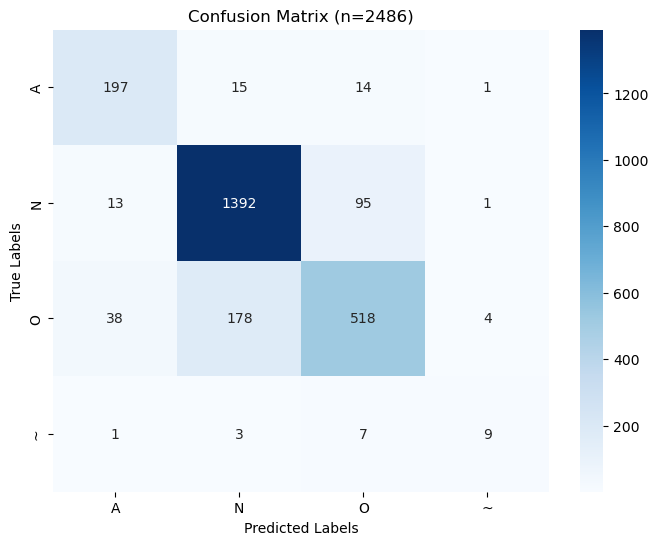

In [10]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])